# Track Activity AI

## Sujet : Reconnaissance d’activité humaine à partir d’un smartphone

Auteur : Elias Khallouk - KHAE23050400

---

### Importation des bibliothèques nécessaires

In [12]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping

2025-03-20 12:24:09.046831: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-20 12:24:09.047675: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-20 12:24:09.050073: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-20 12:24:09.056945: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742487849.069228   13540 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742487849.07

### Définition des chemins vers le dataset

In [14]:
base_path = 'UCI HAR Dataset'
train_path = os.path.join(base_path, 'train')
test_path = os.path.join(base_path, 'test')

train_inertial_path = os.path.join("train", "Inertial Signals")
test_inertial_path = os.path.join("test", "Inertial Signals")

### Chargement des métadonnées

In [16]:
# Charger la liste des features qui servira de noms de colonnes pour les données X
features = pd.read_csv('features.txt',
                       sep=r'\s+', header=None, names=['index', 'feature'])
feature_names = features['feature'].tolist()

# Charger les labels d'activité (pour associer un numéro d'activité à son libellé)
activity_labels = pd.read_csv('activity_labels.txt',
                              sep=r'\s+', header=None, names=['index', 'activity'])
activity_dict = dict(zip(activity_labels['index'], activity_labels['activity']))


In [17]:
features.head()

,index,feature
0,1,tBodyAcc-mean()-X
1,2,tBodyAcc-mean()-Y
2,3,tBodyAcc-mean()-Z
3,4,tBodyAcc-std()-X
4,5,tBodyAcc-std()-Y


In [18]:
activity_labels.head()

,index,activity
0,1,WALKING
1,2,WALKING_UPSTAIRS
2,3,WALKING_DOWNSTAIRS
3,4,SITTING
4,5,STANDING


### Chargement des données d'entraînement

In [20]:
# Fonction pour rendre les noms uniques
def make_unique(names):
    seen = {}
    unique_names = []
    for name in names:
        if name in seen:
            seen[name] += 1
            unique_names.append(f"{name}_{seen[name]}")
        else:
            seen[name] = 0
            unique_names.append(name)
    return unique_names

# Chargement des métadonnées avec des noms de colonnes uniques
features = pd.read_csv('features.txt', sep=r'\s+', header=None, names=['index', 'feature'])
feature_names = make_unique(features['feature'].tolist())

activity_labels = pd.read_csv('activity_labels.txt', sep=r'\s+', header=None, names=['index', 'activity'])
activity_dict = dict(zip(activity_labels['index'], activity_labels['activity']))

# Chargement des données d'entraînement avec les noms de colonnes uniques
X_train = pd.read_csv('train/X_train.txt',
                      sep=r'\s+', header=None, names=feature_names)
y_train = pd.read_csv('train/y_train.txt',
                      sep=r'\s+', header=None, names=['activity'])
subject_train = pd.read_csv('train/subject_train.txt',
                            sep=r'\s+', header=None, names=['subject'])


In [26]:
X_train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892


In [28]:
y_train.head()

,activity
0,5
1,5
2,5
3,5
4,5


In [31]:
subject_train.head()

,subject
0,1
1,1
2,1
3,1
4,1


### Chargement des données de test

In [34]:
X_test = pd.read_csv('test/X_test.txt',
                     sep=r'\s+', header=None, names=feature_names)
y_test = pd.read_csv('test/y_test.txt',
                     sep=r'\s+', header=None, names=['activity'])
subject_test = pd.read_csv('test/subject_test.txt',
                           sep=r'\s+', header=None, names=['subject'])

In [36]:
X_test.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,0.257178,-0.023285,-0.014654,-0.938404,-0.920091,-0.667683,-0.952501,-0.925249,-0.674302,-0.894088,...,0.071645,-0.330370,-0.705974,0.006462,0.162920,-0.825886,0.271151,-0.720009,0.276801,-0.057978
1,0.286027,-0.013163,-0.119083,-0.975415,-0.967458,-0.944958,-0.986799,-0.968401,-0.945823,-0.894088,...,-0.401189,-0.121845,-0.594944,-0.083495,0.017500,-0.434375,0.920593,-0.698091,0.281343,-0.083898
2,0.275485,-0.026050,-0.118152,-0.993819,-0.969926,-0.962748,-0.994403,-0.970735,-0.963483,-0.939260,...,0.062891,-0.190422,-0.640736,-0.034956,0.202302,0.064103,0.145068,-0.702771,0.280083,-0.079346
3,0.270298,-0.032614,-0.117520,-0.994743,-0.973268,-0.967091,-0.995274,-0.974471,-0.968897,-0.938610,...,0.116695,-0.344418,-0.736124,-0.017067,0.154438,0.340134,0.296407,-0.698954,0.284114,-0.077108
4,0.274833,-0.027848,-0.129527,-0.993852,-0.967445,-0.978295,-0.994111,-0.965953,-0.977346,-0.938610,...,-0.121711,-0.534685,-0.846595,-0.002223,-0.040046,0.736715,-0.118545,-0.692245,0.290722,-0.073857


In [38]:
y_test.head()

,activity
0,5
1,5
2,5
3,5
4,5


In [40]:
subject_test.head()

,subject
0,2
1,2
2,2
3,2
4,2


### Exploration et analyse des données

In [43]:
print("Statistiques descriptives de X_train :")
X_train.describe()

Statistiques descriptives de X_train :


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,...,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000
mean,0.274488,-0.017695,-0.109141,-0.605438,-0.510938,-0.604754,-0.630512,-0.526907,-0.606150,-0.468604,...,0.125293,-0.307009,-0.625294,0.008684,0.002186,0.008726,-0.005981,-0.489547,0.058593,-0.056515
std,0.070261,0.040811,0.056635,0.448734,0.502645,0.418687,0.424073,0.485942,0.414122,0.544547,...,0.250994,0.321011,0.307584,0.336787,0.448306,0.608303,0.477975,0.511807,0.297480,0.279122
min,-1.000000,-1.000000,-1.000000,-1.000000,-0.999873,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-0.995357,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.262975,-0.024863,-0.120993,-0.992754,-0.978129,-0.980233,-0.993591,-0.978162,-0.980251,-0.936219,...,-0.023692,-0.542602,-0.845573,-0.121527,-0.289549,-0.482273,-0.376341,-0.812065,-0.017885,-0.143414
50%,0.277193,-0.017219,-0.108676,-0.946196,-0.851897,-0.859365,-0.950709,-0.857328,-0.857143,-0.881637,...,0.134000,-0.343685,-0.711692,0.009509,0.008943,0.008735,-0.000368,-0.709417,0.182071,0.003181
75%,0.288461,-0.010783,-0.097794,-0.242813,-0.034231,-0.262415,-0.292680,-0.066701,-0.265671,-0.017129,...,0.289096,-0.126979,-0.503878,0.150865,0.292861,0.506187,0.359368,-0.509079,0.248353,0.107659
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,1.000000,0.478157,1.000000


#### Visualisation de la répartition des activités dans y_train

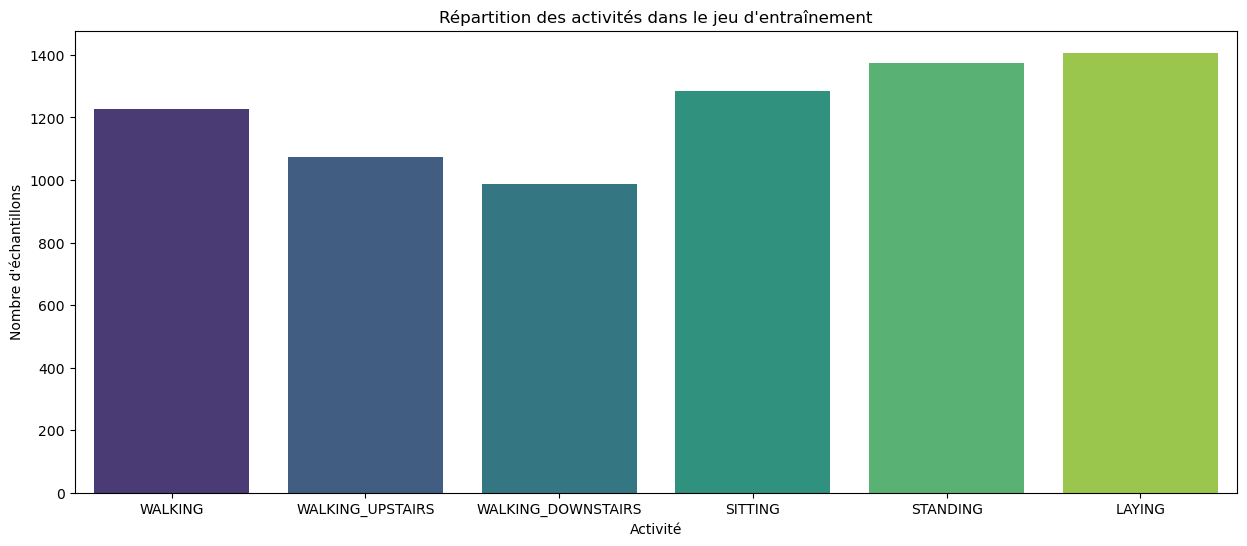

In [46]:
# Récupération du nombre d'échantillons pour chaque activité
activity_counts = y_train['activity'].value_counts().sort_index()
# Conversion des codes en noms d'activités via activity_dict
activity_names = [activity_dict[code] for code in activity_counts.index]

plt.figure(figsize=(15, 6))
sns.barplot(x=activity_names, y=activity_counts.values, hue=activity_names, palette="viridis", dodge=False)
plt.xlabel("Activité")
plt.ylabel("Nombre d'échantillons")
plt.title("Répartition des activités dans le jeu d'entraînement")
plt.legend([], [], frameon=False)
plt.show()

#### Visualisation d'un échantillon de série temporelle de chaque activité

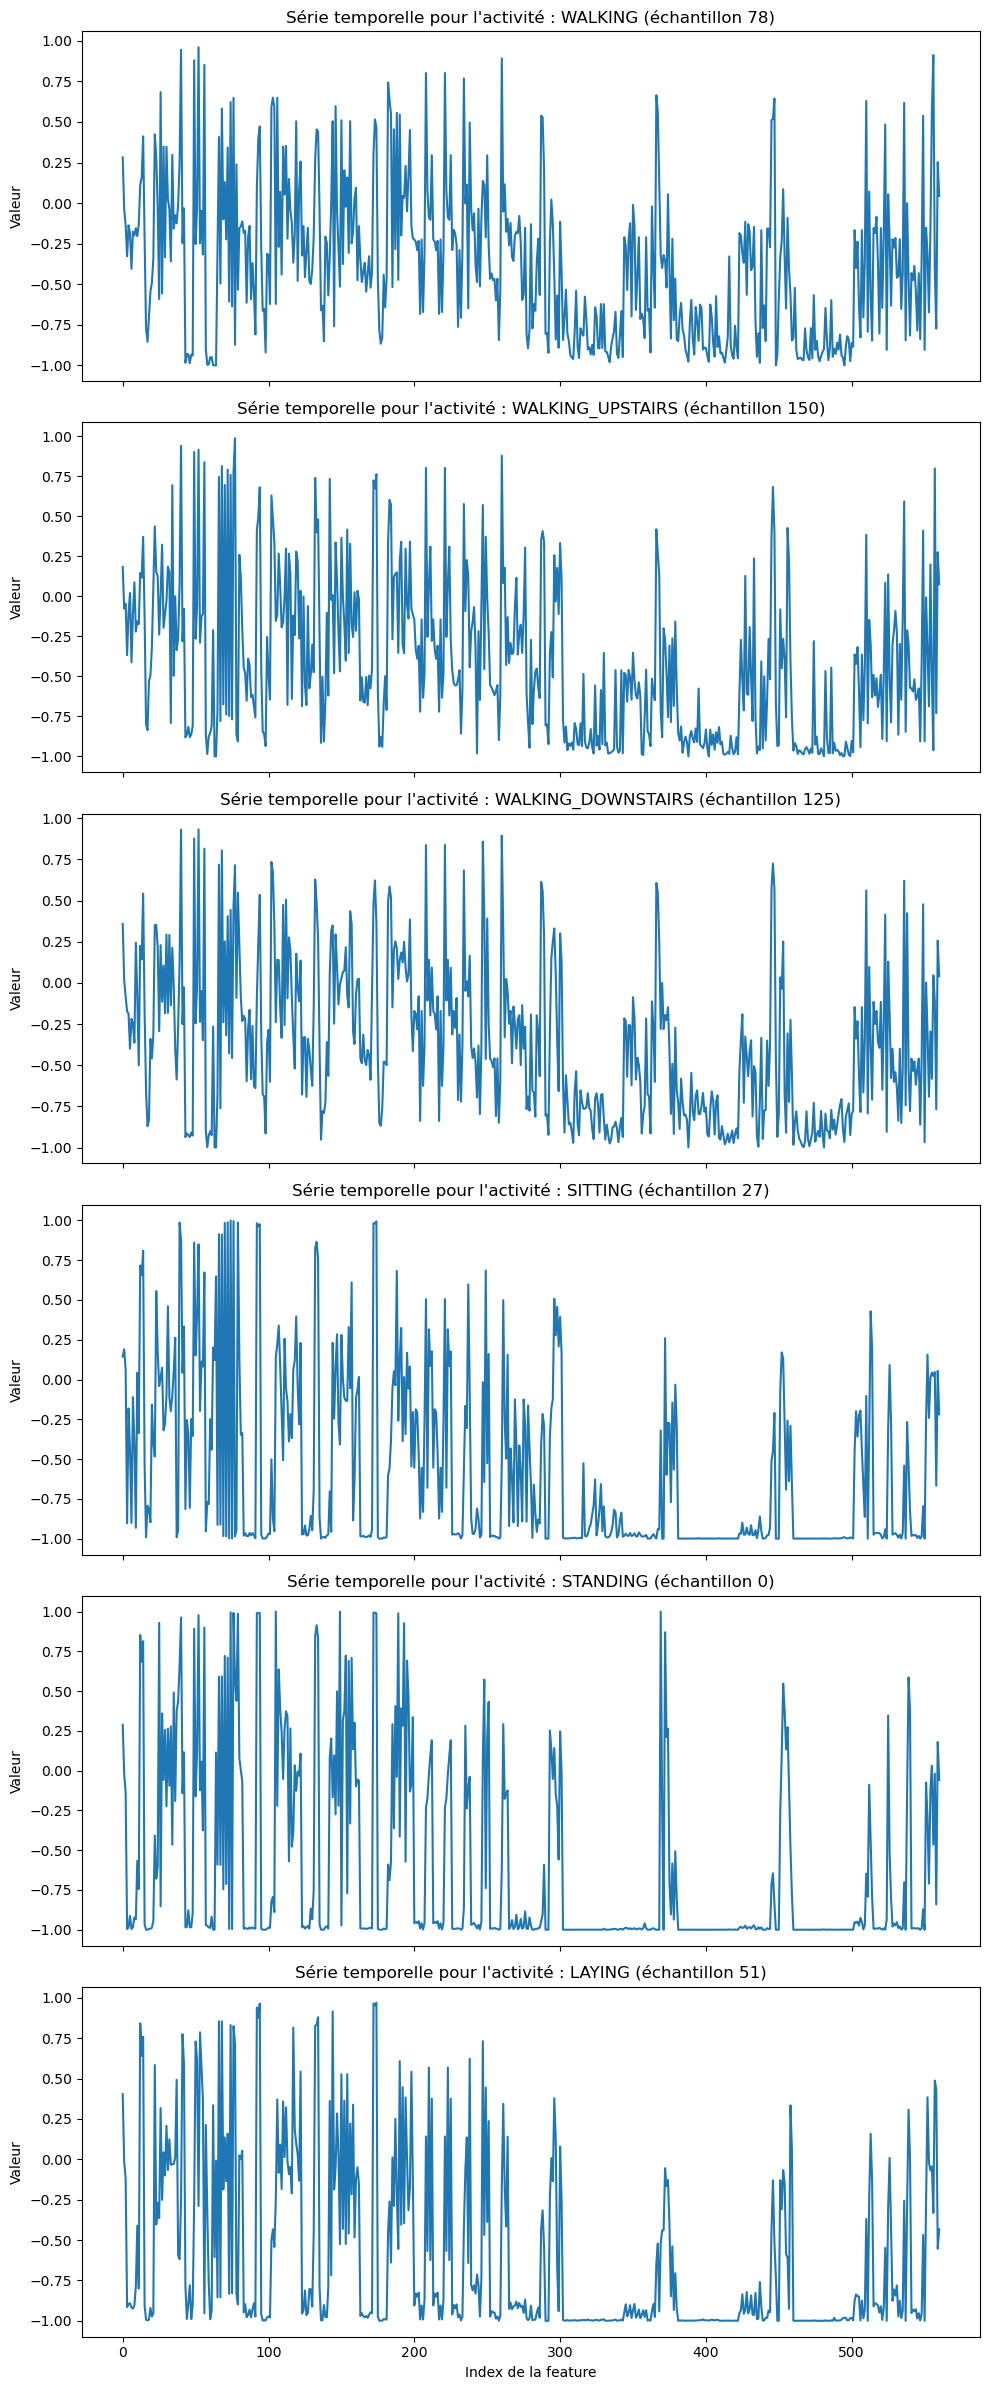

In [49]:
# Récupérer la liste des activités distinctes présentes dans y_train, triées par ordre croissant
unique_activities = sorted(y_train['activity'].unique())
n_activities = len(unique_activities)

# Créer une figure avec un sous-graphe par activité
fig, axs = plt.subplots(n_activities, 1, figsize=(10, 4 * n_activities), sharex=True)

# Pour chaque activité, sélectionner le premier échantillon et tracer sa série temporelle
for ax, act in zip(axs, unique_activities):
    # Trouver l'indice du premier échantillon correspondant à l'activité act
    sample_index = y_train[y_train['activity'] == act].index[0]
    # Tracer la série temporelle pour cet échantillon
    ax.plot(X_train.iloc[sample_index].values)
    ax.set_title(f"Série temporelle pour l'activité : {activity_dict[act]} (échantillon {sample_index})")
    ax.set_ylabel("Valeur")

ax.set_xlabel("Index de la feature")
plt.tight_layout()
plt.show()

### Conception du modèle de réseau de neurones profond

In [52]:
# Les étiquettes vont de 1 à 6, donc on soustrait 1 pour obtenir des indices de 0 à 5
y_train_cat = to_categorical(y_train['activity'].values - 1, num_classes=6)
y_test_cat = to_categorical(y_test['activity'].values - 1, num_classes=6)

# Création d'un jeu de validation à partir de X_train et y_train
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train_cat, test_size=0.2, random_state=42)

In [54]:
# Construction du modèle de réseau de neurones profond
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Dense(6, activation='softmax')  # 6 classes pour les activités
])

# Compilation du modèle
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
from keras.optimizers import SGD

model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9),
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Affichage du résumé du modèle
model.summary()

/home/userdepinfo/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-03-20 12:24:20.689106: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       143,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 221,254 (864.27 KB)

 Trainable params: 219,846 (858.77 KB)

 Non-trainable params: 1,408 (5.50 KB)

In [84]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entraînement du modèle
history = model.fit(X_train_split, y_train_split, 
                    epochs=50, batch_size=32, 
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping])

# Évaluation du modèle sur le jeu de test
test_loss, test_acc = model.evaluate(X_test, y_test_cat)
print("Précision sur le jeu de test : {:.2f}%".format(test_acc * 100))

Epoch 1/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9831 - loss: 0.0513 - val_accuracy: 0.9796 - val_loss: 0.0630
Epoch 2/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9743 - loss: 0.0718 - val_accuracy: 0.9844 - val_loss: 0.0451
Epoch 3/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9797 - loss: 0.0721 - val_accuracy: 0.9816 - val_loss: 0.0544
Epoch 4/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9763 - loss: 0.0619 - val_accuracy: 0.9789 - val_loss: 0.0616
Epoch 5/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9816 - loss: 0.0505 - val_accuracy: 0.9422 - val_loss: 0.1696
Epoch 6/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9732 - loss: 0.0765 - val_accuracy: 0.9776 - val_loss: 0.0681
Epoch 7/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9803 - loss: 0.0568 - val_accuracy: 0.9728 - val_loss: 0.0645
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9601 - loss: 0.1551
Précision sur le jeu de test : 

### Exportation du model

In [91]:
model.save("model.h5")

### Visualisation du model de réseau de neurones profond

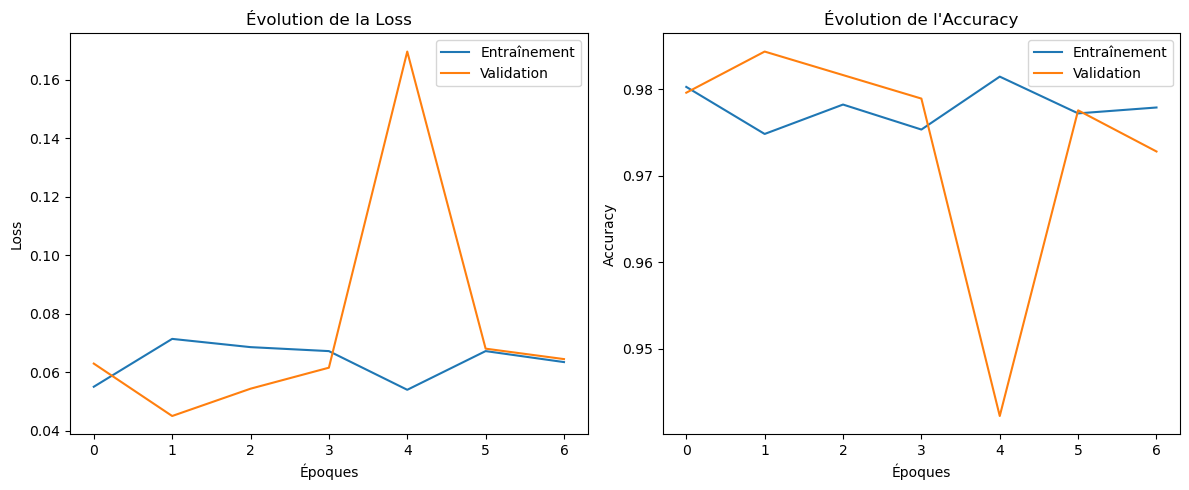

In [86]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Entraînement')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Époques')
plt.ylabel('Loss')
plt.title('Évolution de la Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Entraînement')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.xlabel('Époques')
plt.ylabel('Accuracy')
plt.title('Évolution de l\'Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


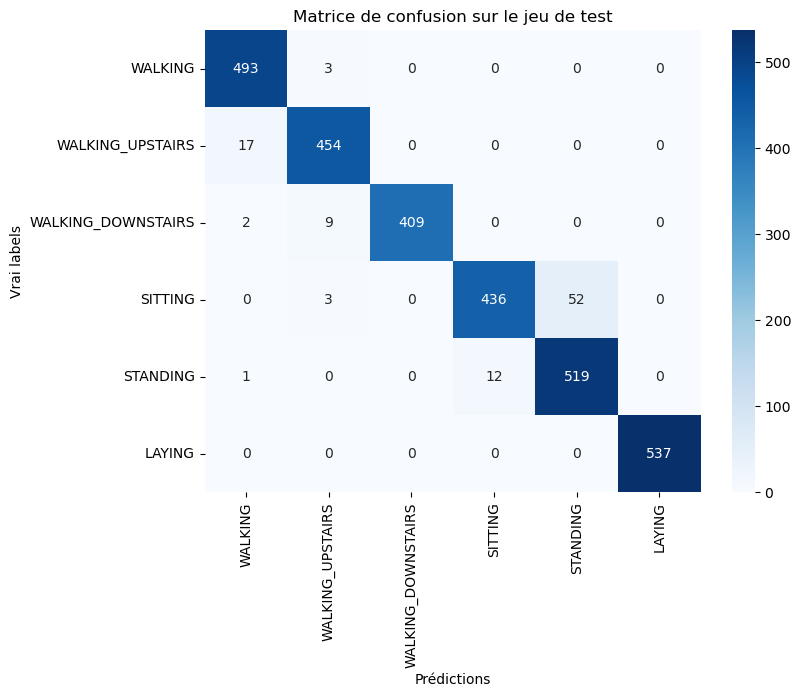

Rapport de classification :
              precision    recall  f1-score   support

           1       0.96      0.99      0.98       496
           2       0.97      0.96      0.97       471
           3       1.00      0.97      0.99       420
           4       0.97      0.89      0.93       491
           5       0.91      0.98      0.94       532
           6       1.00      1.00      1.00       537

    accuracy                           0.97      2947
   macro avg       0.97      0.97      0.97      2947
weighted avg       0.97      0.97      0.97      2947



In [88]:
# Prédictions sur le jeu de test
y_pred_prob = model.predict(X_test)
# On obtient les indices des classes prédites. On ajoute 1 pour revenir aux labels d'origine (1 à 6)
y_pred = np.argmax(y_pred_prob, axis=1) + 1
# Extraction des labels réels du DataFrame y_test
y_true = y_test['activity'].values

# Calcul et affichage de la matrice de confusion
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[activity_dict[i] for i in sorted(activity_dict.keys())],
            yticklabels=[activity_dict[i] for i in sorted(activity_dict.keys())])
plt.xlabel('Prédictions')
plt.ylabel('Vrai labels')
plt.title('Matrice de confusion sur le jeu de test')
plt.show()

# Affichage du rapport de classification
print("Rapport de classification :")
print(classification_report(y_true, y_pred))


### Autre méthode : CNN 1D

#### Preparation du TRAIN brut

In [62]:
train_signal_files = [
    "body_acc_x_train.txt",
    "body_acc_y_train.txt",
    "body_acc_z_train.txt",
    "body_gyro_x_train.txt",
    "body_gyro_y_train.txt",
    "body_gyro_z_train.txt",
    "total_acc_x_train.txt",
    "total_acc_y_train.txt",
    "total_acc_z_train.txt"
]

# Chargement des signaux dans une liste
signals = []
for file in train_signal_files:
    file_path_train = os.path.join(train_inertial_path, file)
    # Chaque fichier contient une matrice de forme (n_samples, timesteps)
    signal_data = np.loadtxt(file_path_train)
    signals.append(signal_data)

# Combinaison des 9 signaux en un tenseur de forme (n_samples, timesteps, n_channels)
# On empile les arrays le long d'une nouvelle dimension à la fin.
X_train_raw = np.stack(signals, axis=-1)
print("X_train_raw shape:", X_train_raw.shape)

y_train_cat = to_categorical(y_train['activity'].values - 1, num_classes=6)

X_train_raw shape: (7352, 128, 9)


#### Preparation du TEST brut

In [65]:
test_signal_files = [
    "body_acc_x_test.txt",
    "body_acc_y_test.txt",
    "body_acc_z_test.txt",
    "body_gyro_x_test.txt",
    "body_gyro_y_test.txt",
    "body_gyro_z_test.txt",
    "total_acc_x_test.txt",
    "total_acc_y_test.txt",
    "total_acc_z_test.txt"
]

# Chargement des signaux dans une liste
signals = []
for file in test_signal_files:
    file_path_test = os.path.join(test_inertial_path, file)
    # Chaque fichier contient une matrice de forme (n_samples, timesteps)
    signal_data = np.loadtxt(file_path_test)
    signals.append(signal_data)

# Combinaison des 9 signaux en un tenseur de forme (n_samples, timesteps, n_channels)
# On empile les arrays le long d'une nouvelle dimension à la fin.
X_test_raw = np.stack(signals, axis=-1)
print("X_test_raw shape:", X_test_raw.shape) 

y_test_cat = to_categorical(y_test['activity'].values - 1, num_classes=6)

X_test_raw shape: (2947, 128, 9)


#### La Conception du CNN 1D

In [76]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization

input_shape = X_train_raw.shape[1:]  # (timesteps, n_channels) ex.: (128, 9)

model_cnn = Sequential([
    Conv1D(filters=128, kernel_size=5, activation='relu', padding='same', input_shape=input_shape),
    BatchNormalization(),
    Conv1D(filters=128, kernel_size=5, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),  # Réduction du dropout pour ne pas trop perdre d'informations
    
    Conv1D(filters=256, kernel_size=5, activation='relu', padding='same'),
    BatchNormalization(),
    Conv1D(filters=256, kernel_size=5, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    
    Conv1D(filters=512, kernel_size=5, activation='relu', padding='same'),
    BatchNormalization(),
    Conv1D(filters=512, kernel_size=5, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(6, activation='softmax')  # 6 classes pour la classification
])

# Compilation du modèle
#model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
from keras.optimizers import SGD

model_cnn.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9),
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


# Affichage du résumé du modèle
model_cnn.summary()


/home/userdepinfo/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 128, 128)       │         5,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 128, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 128, 128)       │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 128, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 64, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 64, 256)        │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 64, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 64, 256)        │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 64, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 32, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 32, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 32, 512)        │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 32, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 32, 512)        │     1,311,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 32, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 16, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 16, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 6)              │         1,54

 Total params: 4,653,190 (17.75 MB)

 Trainable params: 4,649,606 (17.74 MB)

 Non-trainable params: 3,584 (14.00 KB)

In [78]:
early_stopping_cnn = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entraînement du modèle
history_cnn = model_cnn.fit(X_train_raw, y_train_cat, 
                    epochs=25, batch_size=32, 
                    validation_split=0.2,
                    callbacks=[early_stopping])


# Évaluation du modèle sur le jeu de test
test_cnn_loss, test_cnn_acc = model_cnn.evaluate(X_test_raw, y_test_cat)
print("Précision sur le jeu de test : {:.2f}%".format(test_cnn_acc * 100))

Epoch 1/25
184/184 ━━━━━━━━━━━━━━━━━━━━ 36s 188ms/step - accuracy: 0.7266 - loss: 1.4595 - val_accuracy: 0.8001 - val_loss: 0.4365
Epoch 2/25
184/184 ━━━━━━━━━━━━━━━━━━━━ 33s 180ms/step - accuracy: 0.9050 - loss: 0.2834 - val_accuracy: 0.8994 - val_loss: 0.3370
Epoch 3/25
184/184 ━━━━━━━━━━━━━━━━━━━━ 42s 185ms/step - accuracy: 0.9339 - loss: 0.1853 - val_accuracy: 0.9184 - val_loss: 0.2709
Epoch 4/25
184/184 ━━━━━━━━━━━━━━━━━━━━ 30s 161ms/step - accuracy: 0.9037 - loss: 0.2849 - val_accuracy: 0.9205 - val_loss: 0.5298
Epoch 5/25
184/184 ━━━━━━━━━━━━━━━━━━━━ 31s 168ms/step - accuracy: 0.9280 - loss: 0.1868 - val_accuracy: 0.9232 - val_loss: 0.5057
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.7852 - loss: 0.6850
Précision sur le jeu de test : 78.15%


In [82]:
# Entraînement du modèle sur les données brutes
history_cnn = model_cnn.fit(X_train_raw, y_train_cat, epochs=15, batch_size=32, validation_split=0.2)

# Évaluation du modèle sur le jeu de test
test_cnn_loss, test_cnn_acc = model_cnn.evaluate(X_test_raw, y_test_cat)
print("Précision sur le jeu de test : {:.2f}%".format(test_cnn_acc * 100))

Epoch 1/15
184/184 ━━━━━━━━━━━━━━━━━━━━ 33s 177ms/step - accuracy: 0.8995 - loss: 0.3542 - val_accuracy: 0.9069 - val_loss: 1.2103
Epoch 2/15
184/184 ━━━━━━━━━━━━━━━━━━━━ 31s 167ms/step - accuracy: 0.8919 - loss: 0.5435 - val_accuracy: 0.2148 - val_loss: 505.0779
Epoch 3/15
184/184 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.8165 - loss: 0.5459 - val_accuracy: 0.8967 - val_loss: 0.4378
Epoch 4/15
184/184 ━━━━━━━━━━━━━━━━━━━━ 36s 195ms/step - accuracy: 0.9012 - loss: 0.3062 - val_accuracy: 0.9157 - val_loss: 0.3858
Epoch 5/15
184/184 ━━━━━━━━━━━━━━━━━━━━ 38s 208ms/step - accuracy: 0.9195 - loss: 0.2111 - val_accuracy: 0.9252 - val_loss: 0.2416
Epoch 6/15
184/184 ━━━━━━━━━━━━━━━━━━━━ 34s 187ms/step - accuracy: 0.9290 - loss: 0.1770 - val_accuracy: 0.9266 - val_loss: 0.3310
Epoch 7/15
184/184 ━━━━━━━━━━━━━━━━━━━━ 33s 182ms/step - accuracy: 0.9235 - loss: 0.2767 - val_accuracy: 0.9307 - val_loss: 0.2665
Epoch 8/15
184/184 ━━━━━━━━━━━━━━━━━━━━ 33s 179ms/step - accuracy: 0.9260 - loss:

#### Visualisation du CNN 1D

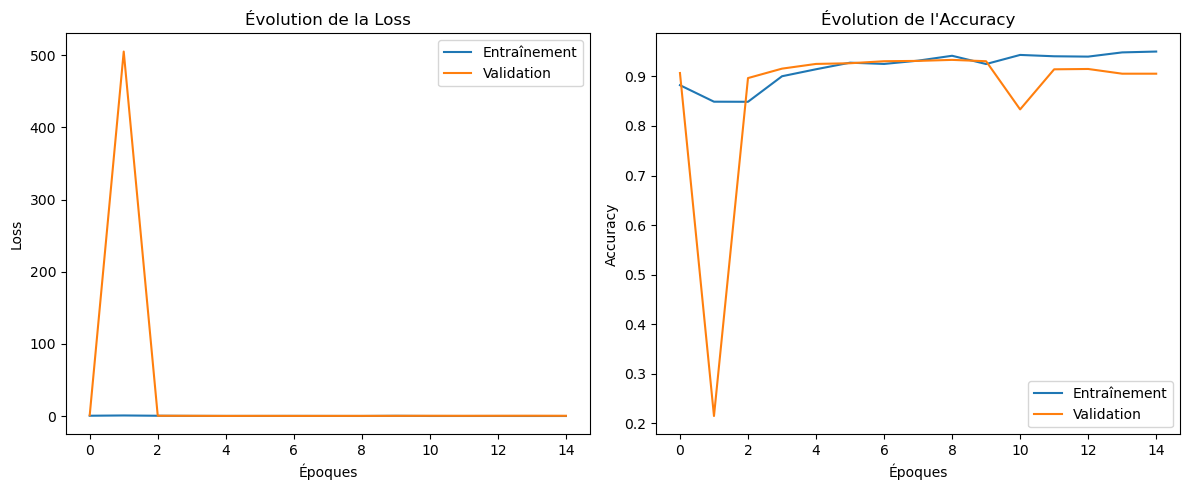

In [88]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['loss'], label='Entraînement')
plt.plot(history_cnn.history['val_loss'], label='Validation')
plt.xlabel('Époques')
plt.ylabel('Loss')
plt.title('Évolution de la Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['accuracy'], label='Entraînement')
plt.plot(history_cnn.history['val_accuracy'], label='Validation')
plt.xlabel('Époques')
plt.ylabel('Accuracy')
plt.title('Évolution de l\'Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step


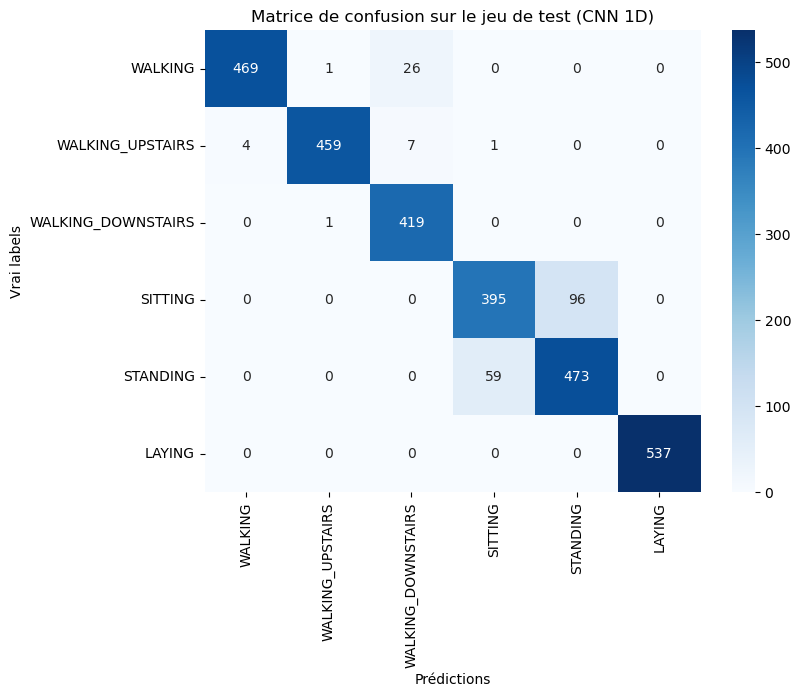

Rapport de classification :
              precision    recall  f1-score   support

           1       0.99      0.95      0.97       496
           2       1.00      0.97      0.98       471
           3       0.93      1.00      0.96       420
           4       0.87      0.80      0.84       491
           5       0.83      0.89      0.86       532
           6       1.00      1.00      1.00       537

    accuracy                           0.93      2947
   macro avg       0.94      0.94      0.93      2947
weighted avg       0.94      0.93      0.93      2947



In [98]:
# Prédictions sur le jeu de test avec le modèle CNN 1D
y_pred_prob = model_cnn.predict(X_test_raw)
# On obtient l'indice de la classe prédite pour chaque échantillon, puis on ajoute 1 pour revenir aux labels originaux (1 à 6)
y_pred = np.argmax(y_pred_prob, axis=1) + 1
# Extraction des labels réels à partir du DataFrame y_test
y_true = y_test['activity'].values

# Calcul de la matrice de confusion et du rapport de classification
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[activity_dict[i] for i in sorted(activity_dict.keys())],
            yticklabels=[activity_dict[i] for i in sorted(activity_dict.keys())])
plt.xlabel('Prédictions')
plt.ylabel('Vrai labels')
plt.title('Matrice de confusion sur le jeu de test (CNN 1D)')
plt.show()

print("Rapport de classification :")
print(classification_report(y_true, y_pred))


#### Comparaison des modeles

In [7]:
print("MLP    : précision sur le jeu de test : {:.2f}% avec un F1-score de 0.97".format(test_acc * 100))
print("CNN 1D : précision sur le jeu de test : {:.2f}% avec un F1-score de 0.93".format(test_cnn_acc * 100))

NameError: name 'test_acc' is not defined

Cependant on ne peut s'empecher de remarquer que le CNN 1D est bien plus stable que le RNP.